# Sentiment analysis with RNN

In [1]:
import numpy as np
import scipy.sparse
import json
import zipfile

import spacy
from gensim import corpora
from gensim.models import tfidfmodel
from gensim.matutils import corpus2csc
from gensim.corpora.dictionary import Dictionary

import matplotlib.pyplot as plt
import seaborn as sns

import sys
from collections import Counter, OrderedDict
from os.path import expanduser
import re, time
from sklearn.model_selection import train_test_split

import torch
import torch.nn.utils.rnn as rnn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from itertools import zip_longest
from operator import itemgetter

ModuleNotFoundError: No module named 'gensim'

In [2]:
re_run = True
torch.cuda.get_device_name(0)

'GeForce GTX 1080'

# Importing

Reviews were tokenized with spacy beforehand, stop words and punctuation were removed.

In [3]:
%%time

if re_run:
    # processed from gensim_walkthrough notebook
    with open('../../data/processed/processed.txt', 'r') as f:
        restaurants = {i:json.loads(line) for i, line in enumerate(f)}

    # different text cleaning for reviews
    with open('../../data/processed/reviews_cleaned.txt', 'r') as f:
        reviews = tuple(json.loads(line) for line in f)

CPU times: user 12.1 s, sys: 1.28 s, total: 13.4 s
Wall time: 13.5 s


In [11]:
def update_dict(line, dc):

        for i in range(len(line)):
            dc.setdefault(line[i], len(dc))
        
def make_labels(lsls):
    now = time.time()
    dc={}
    
    for ls in lsls:
        make_dict(ls, dc=dc)
    print(time.time() - now)
    return dc

# regex tokenize, less accurate
def tokenize(x): return re.findall('\w+', x)

In [36]:
categories = {}
non = []
for i in range(len(restaurants)):
    if 'Restaurants' in restaurants[i]['category']:
    
        update_dict(restaurants[i]['category'], dc = categories)
    if any(item in restaurants[i]['category'] for item in ['Chiropractors', 'Contractors']):
        non.append(restaurants[i])

In [38]:
for item in restaurants[0]['category']:
    print(item)

Nightlife
American (Traditional)
Pubs
Restaurants
Bars


In [118]:
def create_labels(num_documents, num_labels, restaurants):
    
    sparse = np.zeros((num_documents, num_labels))
    for i in range(len(reviews)):
        for item in restaurants[i]['category']:
            sparse[i, categories[item]] = 1
    
    return sparse

In [117]:
# test
check = []
for i in range(len(restaurants)):
    res=[categories[item] for item in restaurants[i]['category']]
    res.sort()
    check.append(np.mean(np.argwhere(sparse[i,]).reshape(1,-1)[0]==np.array(res)))
min(check)

1.0

In [5]:
# rebuild reviews from json data

label_dc = {}
i=0
texts= []
idx = []

for ls in restaurants.values():
    
    
    if 'Restaurants' in ls['category']:
        try:
            idx.append(i), make_dict(ls['category'], adc=label_dc), texts.append(tokenize(ls['text'].lower()))
        except Exception as e:
            print(e, i)

    i +=1
    if i % 100000 == 0:
        print(f'{i} lines have completed there are currently {len(label_dc.keys())} keys')

# vocab = make_labels(texts)
# corpus = [[vocab[word] for word in line] for line in texts]

## Building vocab with gensim

Skipping a step by not creating two dictionaries for train and test, they get recombined anyway for an update of new data though.

In [35]:
%%time

if re_run:
    
    # create dictionary
    dict_yelp = corpora.Dictionary(reviews)
    # tune corpus to get a smaller dictionary and therefore a smaller doc_term matrix, 
    # embeddings will still work but bow will not fit into 8gb gpu otherwise
    dict_yelp.filter_extremes(no_below=40, no_above=.95, keep_n=30000)
    dict_yelp.save('../../data/processed/dictionary')

else:
    
    dict_yelp = corpora.Dictionary.load('../../data/processed/dictionary')

print(len(dict_yelp))

12590
CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 9.25 ms


In [36]:
if re_run:
    # most common words
    top_ids = sorted(dict_yelp.dfs.items(), key=itemgetter(1), reverse=True)[0:100]
    counts=[(dict_yelp[item[0]], item[1]) for item in top_ids]
    counts

In [37]:
def text_sequencer(dictionary, text, max_len=200):
    
    processed = []
    # in case the word is not in the dictionary because it was filtered out use this number to represent an out of set id 
    dict_final = len(dictionary.keys())+1
    
    for i, word in enumerate(text):        
        if i > max_len-1:
            break
        if word in dictionary.token2id.keys():
    # remember the ids have an offset of 1 for this because 0 represents a padded value        
            processed.append(dictionary.token2id[word] + 1) 
        else:
            processed.append(dict_final)
    
    return processed

In [38]:
%%time

if re_run:
    
    corpus = [text_sequencer(dict_yelp, review) for review in reviews]
    #corpus_ = prep_data(corpus)
    
    # converted corpus array, will be a np matrix
    np.save('../../data/processed/corpus.npy', corpus)

else:
    
    corpus = np.load('../../data/processed/corpus.npy')

CPU times: user 2.41 s, sys: 255 ms, total: 2.67 s
Wall time: 2.65 s


In [39]:
def make_dataset(data, indices):
    ls=[]
    for idx in indices:
        ls.append(data[idx])
    return ls
    

## Integrating glove embeddings

In [40]:
def load_embeddings(emb_path = '/projects/embeddings/data/'):
    # load glove vectors
    embeddings_index={}
    with zipfile.ZipFile(expanduser("~")+ emb_path +'glove.6B.zip', 'r') as f:
        with f.open('glove.6B.100d.txt', 'r') as z:
            for line in z:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    
    return embeddings_index

def id_to_glove(dict_yelp):
    
    embeddings_index = load_embeddings()
    conversion_table = {}
    for word in dict_yelp.values():
        if bytes(word, 'utf-8') in embeddings_index.keys():
            conversion_table[dict_yelp.token2id[word]+1] = embeddings_index[bytes(word, 'utf-8')]
        else:
            conversion_table[dict_yelp.token2id[word]+1] = np.random.normal(0, .32, 100)
            
    embedding_matrix = np.vstack((np.zeros(100), np.vstack(conversion_table.values()), np.random.randn(100)))
    
    return embedding_matrix

In [41]:
%%time
embedding_matrix = id_to_glove(dict_yelp)


CPU times: user 12.7 s, sys: 188 ms, total: 12.9 s
Wall time: 12.3 s


## Labels

In [42]:
def convert_rating(rating):
    if rating in [4,5]:
        return 1
    elif rating in [1,2]:
        return 0
    else:
        return None
    
def get_rating_set(corpus, stars):
    
    mids = set()
    
    def get_mids():

        for i, rating in enumerate(stars):
            if rating is None:
                mids.add(i)
    
    get_mids()
    filtered_corpus, filtered_stars = [], []
    
    for i in range(len(corpus)):
        if i in mids:
            next
        else:
            filtered_corpus.append(corpus[i]), filtered_stars.append(stars[i])
    
    return filtered_corpus, filtered_stars

In [43]:
if re_run:
    stars = [convert_rating(restaurants[i]['stars']) for i in range(len(restaurants))]
    data, lab = get_rating_set(corpus, stars)
    with open('../../data/numpy/ratings.npy', 'wb') as outf:
        np.save(outf, lab)
    with open('../../data/numpy/corpus.npy', 'wb') as outf:
        np.save(outf, data)
else:
    data, lab = np.load('../../data/numpy/corpus.npy'), np.load('../../data/numpy/ratings.npy')

/home/ryeyoo/miniconda3/envs/torchdl/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


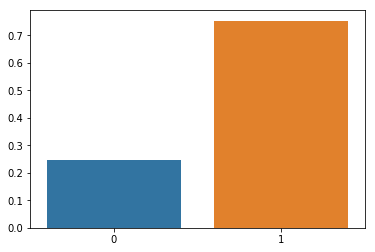

In [15]:
sns.barplot(x = lab, y = lab, estimator=lambda x: len(x)/len(lab))
plt.show()

## Modeling 

In [44]:
def prep_data(sents, targets, stack=False, pad = False, pack = False, sort=False):
    
    # creates index, filters out no text
    res =[(i, line, targets[i], len(line)) for i, line in enumerate(sents)]
    res = filter(lambda x:x[3] > 0, res)
    
    if sort:
        res = sorted(res, key=itemgetter(3), reverse=True)
    
    idx, seqs, labels, seq_lens =[], [], [], []

    for item in res:
    
        idx.append(item[0]), seqs.append(item[1]), labels.append(item[2]), seq_lens.append(item[3])
    
    if pad:
        # note that zip longest transposes the matrix
        padded=list(zip_longest(*seqs, fillvalue=0))
        # transpose back
        seqs=list(zip_longest(*padded))
    
    if pack:
        # assumes no padding
        seqs= rnn.pack_sequence(seqs) 
    
    if stack:
        # stack if all padded to same lens
        seqs=np.stack(seqs)
        
    return idx, seqs, np.array(labels), np.array(seq_lens)

# need to add original index so we can resort in case of packing
class CorpusData(Dataset):
    
    def __init__(self, index=None, data=None, labels=None, lens=None, test_size=0.25):
        #super().__init__()
        self.corpus = data
        self.labels = labels
        self.test_size = test_size
        self.lens = lens
        self.idx = index
        self.tr_idx, self.test_idx = None, None
        
    def __len__(self):
        return self.corpus.__len__()
    
    def __getitem__(self, i):
        
        if self.lens is None:
            return self.corpus[i], self.labels[i]
        else:
            return self.corpus[i], self.labels[i], self.lens[i]
    
    @classmethod
    def split_validation(cls, corpus):
        
        tr_idx, val_idx = train_test_split(range(len(corpus)))
        return cls(corpus[tr_idx]), cls(corpus[val_idx])

In [45]:
def sort_array(all_lens): 
    return np.unique(all_lens), np.bincount(all_lens), len(np.unique(all_lens)), len(np.bincount(all_lens))

In [46]:
def resort_lens(idx, lens):
    resorted_lenidx = np.array(sorted(zip(idx, lens), key=itemgetter(1), reverse=True))
    return resorted_lenidx

def resample_data(data, label, idx, lens):
    
        if isinstance(data, np.ndarray):
            pass
        else:
            data= np.array(data)
        assert len(data) == len(label)
        sorted_ = resort_lens(idx, lens)
        return data[sorted_[:,0]], label[sorted_[:,0]], sorted_[:,1]
    
#trainiter = iter(train_loader)

def sort_lens(x, y, lens):
    x=torch.stack(x,dim=1)
    lens_, indices = lens.sort(descending=True)
    x_, y_ = x[indices], y[indices]
    return x_, y_, lens_

def split(sorted_data, sorted_lab, all_lens, random_state=5):
    
    tr_idx, val_idx, tr_lens, val_lens = train_test_split(range(len(all_lens)), all_lens, \
                     test_size = 0.2, stratify=all_lens,\
                     random_state=random_state)
    
    train, train_y, tr_lens_ = resample_data(sorted_data, sorted_lab, tr_idx, tr_lens)
    val, val_y, val_lens_ = resample_data(sorted_data, sorted_lab, val_idx, val_lens)
    return {'train':[tr_idx, train, train_y, tr_lens_], 'val':[val_idx, val, val_y, val_lens_]}

In [47]:
og_idx, unsorted_data, unsorted_lab, all_lens = prep_data(data, lab, sort=False, pad=True, stack=True)
train, val, train_y, val_y = train_test_split(unsorted_data, unsorted_lab)

In [20]:
# %%time

# # sorting needed for packing sequences
# if re_run:
#     og_idx, sorted_data, sorted_lab, all_lens = prep_data(data, lab, sort=True, pad=True, stack=True)
#     np.save('../../data/processed/sorted_arrays.npy', [sorted_data, sorted_lab] )
#     np.save('../../data/processed/idx_lens.npy', [og_idx, all_lens])
# else:
#     sorted_data, sorted_lab = np.load('../../data/processed/sorted_arrays.npy')
#     og_idx, all_lens = np.load('../../data/processed/idx_lens.npy')
#     sorted_data = np.stack(sorted_data)

# split_dict = split(sorted_data, sorted_lab, all_lens)
# _, train, train_y, tr_lens = split_dict['train']
# _, val, val_y, val_lens = split_dict['val']

In [48]:
def get_batches(x, y, bsize):
    
    count = int(len(y)/bsize)+1
    def convert(lsls):
        return torch.stack([torch.tensor(ls) for ls in lsls])
    for i in range(count):
        a,b,c = len(y[i*bsize:(i+1)*bsize]), x[i*bsize:(i+1)*bsize], y[i*bsize:(i+1)*bsize]
        yield a, convert(b), torch.tensor(c) 
        


In [106]:
class RNN(nn.Module):
    
    # weights are vocabsize x embedding length
    def __init__(self, emb_weights, batch_size, input_len):
    
        super().__init__()
        # vocab size in, hidden size out
        self.batch_size = batch_size
        self.embed_layer = nn.Embedding(emb_weights.shape[0], emb_weights.shape[1])
        self.emb_weights = emb_weights
        # input of shape (seq_len, batch, input_size) https://pytorch.org/docs/stable/nn.html
        self.lstm = nn.LSTM(input_len, input_len)
        
        """Input: (N, *, \text{in\_features})(N,∗,in_features) where *∗ means any number of additional dimensions
        Output: (N, *, \text{out\_features})(N,∗,out_features) where all but the last dimension are the same shape as the input."""
        
        self.fc1 = nn.Linear(input_len,1)
        self.fc2 = nn.Linear(emb_weights.shape[1], 1)
        

    def load_weights(self):
        self.embed_layer.load_state_dict({'weight': self.emb_weights})
        return self
    
    def forward(self, inputs, p=0.2, verbose=False):
        
        
        embeds = self.embed_layer(inputs)
        
        nn.Dropout2d(p=p, inplace=True)(embeds)
        
        if verbose:
            print('embedding shape %s' % (embeds.shape,))
        
        out, (hidden, cell) = self.lstm(embeds.permute(0,2,1))
        
        if verbose:
            print('lstm out shape %s' % (out.shape,))
        
        out = F.relu(self.fc1(out))
        if verbose:
            print('fc1 out shape %s' % (out.shape,))
        
        fout = self.fc2(out.view(1,-1,100))
        if verbose:
            print('final %s' % (fout.shape,))
        #prob = torch.sigmoid(fout)
        
        return fout.view(-1) 
    
class RNNpacked(nn.Module):
    
    def __init__(self, emb_weights, batch_size, input_len):
 
        super().__init__()
        
        # vocab size in, hidden size out
        self.batch_size = batch_size
        self.embed_layer = nn.Embedding(emb_weights.shape[0], emb_weights.shape[1])
        self.emb_weights = emb_weights
        self.dropout1 = nn.Dropout(p=0.5, inplace=True) 
        self.dropout3d1 = nn.Dropout3d(p=0.5, inplace=True)
        self.dropout3d2 = nn.Dropout3d(p=0.5, inplace=True)
        
        # input of shape (seq_len, batch, input_size) https://pytorch.org/docs/stable/nn.html
        self.lstm = nn.LSTM(emb_weights.shape[1], emb_weights.shape[1])
        self.dropout2d1 = nn.Dropout2d(p=0.5, inplace=True)
        self.dropout2d2 = nn.Dropout2d(p=0.5, inplace=True)
        
        """Input: (N, *, \text{in\_features})(N,∗,in_features) where *∗ means any number of additional 
        dimensions Output: (N, *, \text{out\_features})(N,∗,out_features) where all but the last dimension 
        are the same shape as the input."""
        
        self.fc1 = nn.Linear(emb_weights.shape[1], 1)
        self.fc2 = nn.Linear(input_len,1)
        
    def load_weights(self):
        self.embed_layer.load_state_dict({'weight': self.emb_weights})
        return self
    
    def forward(self, inputs, input_lengths=None, verbose=False):
        if verbose:
            print('inputs', inputs.shape)
            
        #self.dropout1(inputs)
        embeds = self.embed_layer(inputs)
        if verbose:
            print('embeds', embeds.shape)
            print(embeds)
        
        #self.dropout3d1(embeds)
        self.dropout2d1(embeds)
        
        if verbose:    
            print(embeds)
        packed = rnn.pack_padded_sequence(embeds, input_lengths, batch_first=True)
        
        if verbose:
            print('packed', packed[0].shape)
        out, (hidden, cell) = self.lstm(packed)
        unpacked, lengths = rnn.pad_packed_sequence(out, total_length=200, batch_first=True)
        
        if verbose:
            print('unpacked', unpacked.shape)
        out = self.fc1(unpacked)
        if verbose:
            print('out', out.shape)
        
        self.dropout2d2(out)
        #self.dropout3d2(out)
        
        fout = self.fc2(out.permute(0,2,1))
        if verbose:
            print('fout', fout.shape)
        prob = F.sigmoid(fout)
        
        return fout.view(-1)


In [72]:
#traincls = CorpusData(data=train, labels=train_y, lens=tr_lens)
traincls = CorpusData(data=train, labels=train_y)
train_loader = DataLoader(traincls, batch_size=2)

In [77]:
def test_next(trainiter):
    iterator = iter(trainiter)
    x, y= next(iterator)
    return x,y

In [91]:
x, y = test_next(train_loader)

model(x.to(device), verbose=True)

embedding shape torch.Size([2, 200, 100])
lstm out shape torch.Size([2, 100, 200])
fc1 out shape torch.Size([2, 100, 1])
final torch.Size([1, 2, 1])


tensor([0.0397, 0.0408], device='cuda:0', grad_fn=<ViewBackward>)

In [107]:
# see https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cuda'
batch_size = 200
input_len = 200
emb_t = torch.from_numpy(embedding_matrix)
emb = nn.Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1])
emb.load_state_dict({'weight': emb_t})
model = RNN(emb_weights=emb_t, batch_size=batch_size, input_len=input_len)
model.load_weights()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.7, 0.99), weight_decay=1e-5)
loss_function = nn.BCEWithLogitsLoss()
# model_packed = RNNpacked(emb_weights=emb_t, batch_size=batch_size, input_len=input_len)
# model_packed.load_weights()
# model_packed.to(device)
# optimizer = optim.Adam(model_packed.parameters(), lr=0.001)
#torch.nn.utils.clip_grad_norm(mdl_sgd.parameters(),clip)

def fit(model, loss_function, opitmizer, dataclass, batch_size, epochs, device, packed=False):
    
    start = time.time()
    model.train()
    
    epoch_count = 0
    losses = []
    train_loader = DataLoader(dataclass, batch_size=batch_size)

    def train_epoch():
        i=0
        n=len(dataclass)
        for j, (sent, target) in enumerate(train_loader):
            
            optimizer.zero_grad()
            
            if isinstance(sent, list):
                sent = torch.stack(sent, dim =1)
                
            if packed:
                
                #seqs, labels, lens_ = sort_lens(sent, target, lens)
                sent, labels = sent.long().to(device), target.float().to(device)
                log_probs = model(sent.to(device), lens.to(device))
            else:
                sent, labels = sent.long().to(device), target.float().to(device)
                log_probs = model(sent)
            
            loss = loss_function(log_probs, labels.float().to(device))
            
            # gets graident
            loss.backward()
            
            # clips high gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.3, norm_type=2)
            
            # updates with new gradient
            optimizer.step()
            
            i += len(labels)
            losses.append(loss.item())
            if i % (batch_size*100) == 0:
                print(f"""{i/n:.2f} of rows completed in {j+1} cycles, current loss at {np.mean(losses[-30:]):.4f}""" )

    
    print('fitting model...')

    for epoch in range(epochs):
    
        train_epoch()
        
        epoch_count += 1
        print(f'epoch {epoch_count} complete')
    print(f'fit complete {time.time()-start:.0f} seconds passed')
    return losses


In [109]:
%%time
# import pdb; pdb.set_trace()
losses = fit(model, loss_function, optimizer, 
                    traincls, batch_size, 2, device=device, 
                    packed=False)

fitting model...
0.06 of rows completed in 100 cycles, current loss at 0.1773
0.13 of rows completed in 200 cycles, current loss at 0.1830
0.19 of rows completed in 300 cycles, current loss at 0.1782
0.26 of rows completed in 400 cycles, current loss at 0.1816
0.32 of rows completed in 500 cycles, current loss at 0.1856
0.38 of rows completed in 600 cycles, current loss at 0.1744
0.45 of rows completed in 700 cycles, current loss at 0.1846
0.51 of rows completed in 800 cycles, current loss at 0.1790
0.57 of rows completed in 900 cycles, current loss at 0.1828
0.64 of rows completed in 1000 cycles, current loss at 0.1814
0.70 of rows completed in 1100 cycles, current loss at 0.1778
0.77 of rows completed in 1200 cycles, current loss at 0.1786
0.83 of rows completed in 1300 cycles, current loss at 0.1963
0.89 of rows completed in 1400 cycles, current loss at 0.1792
0.96 of rows completed in 1500 cycles, current loss at 0.1815
epoch 1 complete
0.06 of rows completed in 100 cycles, current

In [122]:
for item in optimizer.param_groups:
    print(item['lr'])

0.001


In [97]:
from matplotlib import pyplot as plt

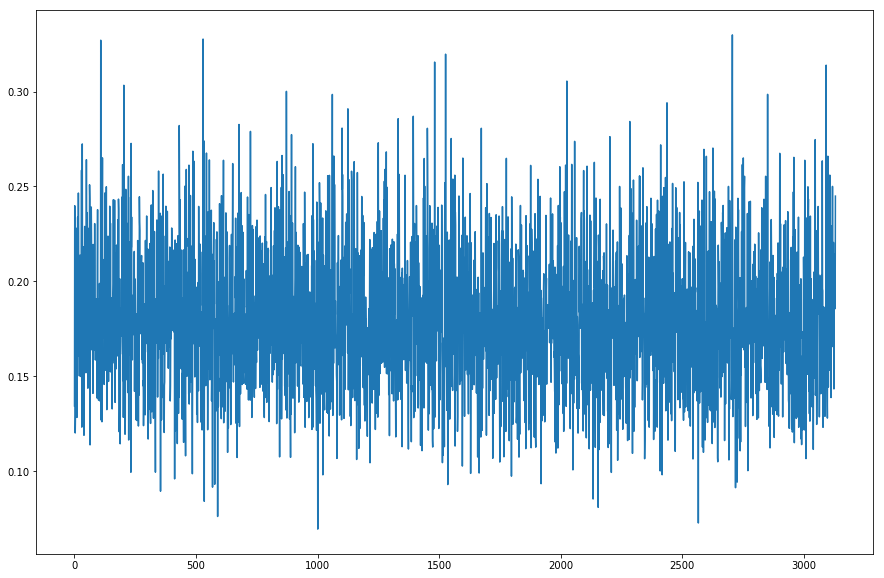

In [123]:
plt.figure(figsize = (15,10))
_ = plt.plot(losses)
# plt.xlim(0, 500)
# plt.ylim(0,.7)

In [124]:
valcls = CorpusData(data=val, labels=val_y)
#val_loader = DataLoader(valcls, batch_size=250)

def eval_model(model, valcls, loss_function, batch_size):
    
    val_loader = DataLoader(valcls, batch_size=batch_size)
    preds = []; targets = []
    with torch.no_grad():

        model.eval()
        for sent, target in val_loader:
            #seqs, labels, lens_ = sort_lens(sent, target, lens)
            #seqs = seqs.long().to(device)

            res = model(sent.cuda())
            
            preds.append(res), targets.append(target)
    
    res = torch.cat(preds).cpu()
    tru = torch.cat(targets).cpu()
    
    print(loss_function(res, tru.float()))    
    

    return res, tru

preds, tru = eval_model(model, valcls, loss_function, 500)

RuntimeError: CUDA error: unspecified launch failure

In [113]:
def classify(true, preds, cutoff):
    #preds = 1/(1+np.exp(-preds))
    
    res = np.greater(preds, np.array(cutoff))
    recall = np.sum(res*true) / np.sum(true)
    precision = np.sum(res*true) / np.sum(res)
    return {'accuracy':round(np.mean(np.equal(true, res)), 4), 'precision': round(precision,4),\
            'recall': round(recall, 4), 'combined':round(precision*recall,4)}

def get_reviewtext(row): 
    return ' '.join([dict_yelp[item-1] for item in traincls[row][0] if (item < 12589) and (item != 0)])

In [115]:
get_reviewtext(int(len(traincls)*.5))

'this be the only chinese bakery stop by on trip the u pick style set up be gross in the ideal world open a pastry cover select the big or whatev float boat bun tart and close the cover afterwards in the real world the pastry be flip upside down poke smash and literally i kid not all the cover be leave open definitely not for a person some of the bun have familiar name but certainly be not the same thing as sf la price although still budget friendly be high than the usa'

In [127]:
from sklearn.metrics import precision_score, recall_score

In [132]:
1/(1+np.exp(-preds.numpy()))

array([0.9125508 , 0.95354444, 0.9868199 , ..., 0.90125835, 0.896096  ,
       0.9811478 ], dtype=float32)

In [146]:
yhat = 1/(1+np.exp(-preds.numpy())) > .5 

In [151]:
for i in range(19):
    cutoff = (1+i) * .05
    #yhat=1/(1+np.exp(-preds.numpy())) > cutoff
    print(f'cutoff of {round(cutoff, 2)} :  {classify(tru.numpy(), 1/(1+np.exp(-preds.numpy())), cutoff)}')
    #print(f'{precision_score(tru.float().numpy(), yhat), recall_score(tru.float().numpy(), yhat)}')

cutoff of 0.05 :  {'accuracy': 0.8499, 'precision': 0.8346, 'recall': 0.9983, 'combined': 0.8332}
cutoff of 0.1 :  {'accuracy': 0.8756, 'precision': 0.8605, 'recall': 0.996, 'combined': 0.8571}
cutoff of 0.15 :  {'accuracy': 0.8914, 'precision': 0.878, 'recall': 0.9937, 'combined': 0.8725}
cutoff of 0.2 :  {'accuracy': 0.9026, 'precision': 0.8914, 'recall': 0.9912, 'combined': 0.8836}
cutoff of 0.25 :  {'accuracy': 0.9108, 'precision': 0.9025, 'recall': 0.9881, 'combined': 0.8918}
cutoff of 0.3 :  {'accuracy': 0.9169, 'precision': 0.9119, 'recall': 0.9846, 'combined': 0.8979}
cutoff of 0.35 :  {'accuracy': 0.9218, 'precision': 0.9203, 'recall': 0.9809, 'combined': 0.9027}
cutoff of 0.4 :  {'accuracy': 0.9255, 'precision': 0.9279, 'recall': 0.9768, 'combined': 0.9064}
cutoff of 0.45 :  {'accuracy': 0.9281, 'precision': 0.9352, 'recall': 0.9717, 'combined': 0.9087}
cutoff of 0.5 :  {'accuracy': 0.93, 'precision': 0.942, 'recall': 0.9663, 'combined': 0.9103}
cutoff of 0.55 :  {'accuracy':

In [ ]:
def evaluate(val, val_y, regression = False):
    
        
    preds = model.predict(val)
    #idx = np.random.randint(0, len(val_y), 5000)
    pred_err = np.subtract(val_y.astype('float32'), preds.reshape(-1))
    sns.distplot(pred_err)
    plt.show()
   
    if regression:
        rmse = np.sqrt(np.mean(pred_err**2))
        print('rmse : %.4f' % rmse)
    else:
        cond_error = round((abs(pred_err) >= 0.5).sum()/len(pred_err), 4)
        binary_cross_entropy = np.mean(
                                        val_y * np.log(preds.reshape(-1)) + \
                                       (1-val_y) * np.log(1-preds.reshape(-1))
        ) 
    
        print('prob error is greater than 0.5 is %.4f' % cond_error)
        print('binary cross entropy is %.4f' % binary_cross_entropy)
    